Cleaned Dataset Snapshot:
                                               Title  \
0                                 The Guv'nor, Spain   
1  Bread & Butter 'Winemaker's Selection' Chardon...   
2       Oyster Bay Sauvignon Blanc 2022, Marlborough   
3                   Louis Latour MAcon-Lugny 2021/22   
4  Bread & Butter 'Winemaker's Selection' Pinot N...   

                                         Description  Price Capacity  \
0  We asked some of our most prized winemakers wo...   9.99     75CL   
1  This really does what it says on the tin. ItaT...  15.99     75CL   
2  Oyster Bay has been an award-winning gold-stan...  12.49     75CL   
3  WeaTMve sold this wine for thirty years a and ...  17.99     75CL   
4  Bread & Butter is that thing that you can coun...  15.99     75CL   

             Grape Secondary Grape Varieties       Closure      Country  Unit  \
0      Tempranillo                       NaN  Natural Cork        Spain  10.5   
1       Chardonnay                       N

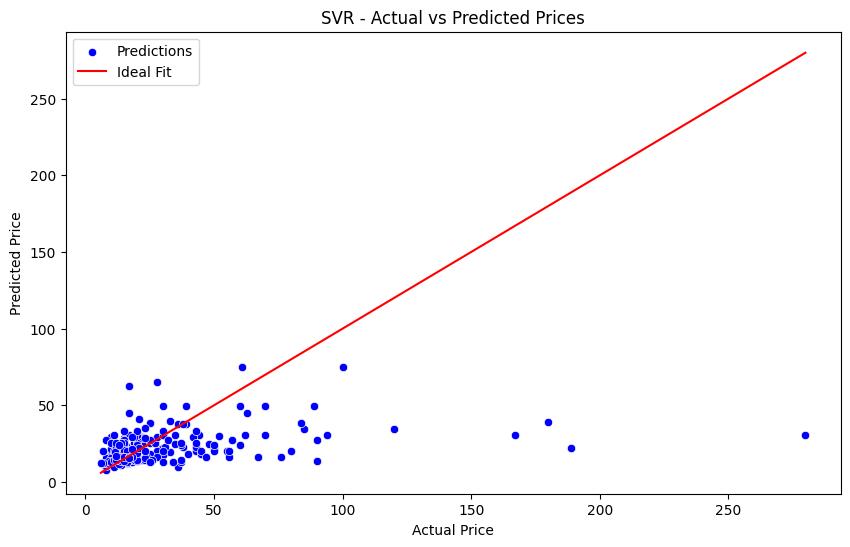

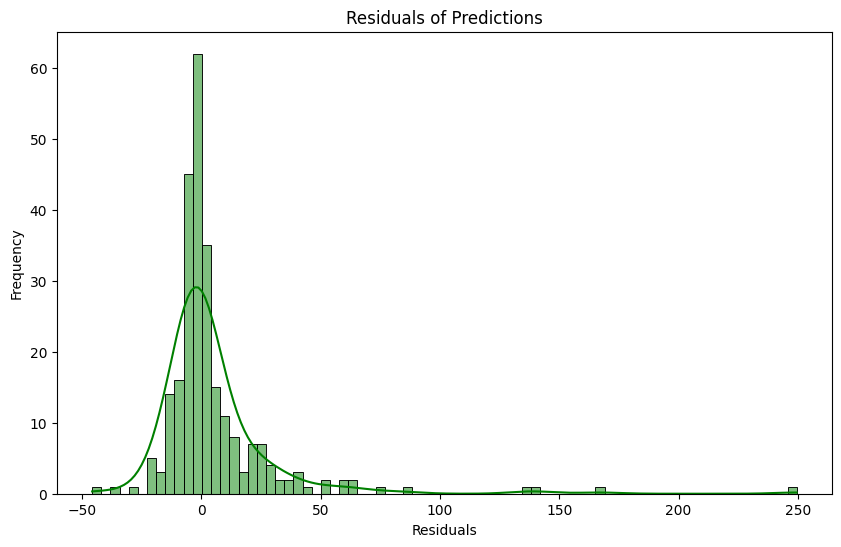

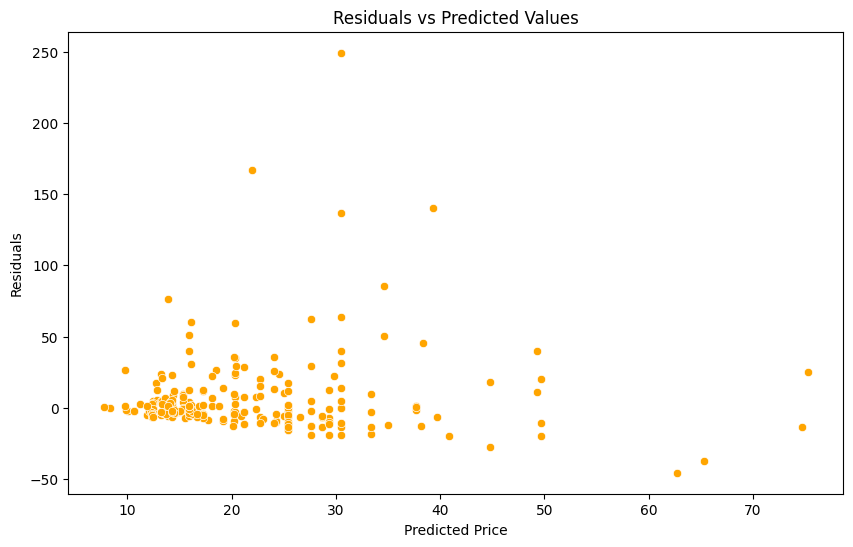


Calculating Permutation Importance...


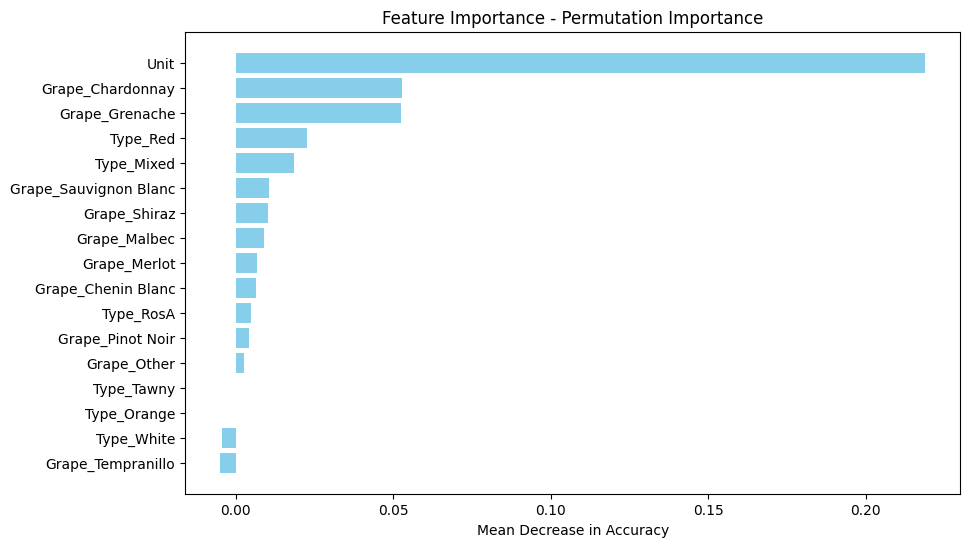


Feature Importance Scores:
Unit: 0.2188
Grape_Chardonnay: 0.0528
Grape_Grenache: 0.0525
Type_Red: 0.0226
Type_Mixed: 0.0183
Grape_Sauvignon Blanc: 0.0104
Grape_Shiraz: 0.0102
Grape_Malbec: 0.0088
Grape_Merlot: 0.0069
Grape_Chenin Blanc: 0.0064
Type_RosA: 0.0047
Grape_Pinot Noir: 0.0040
Grape_Other: 0.0025
Type_Tawny: 0.0000
Type_Orange: 0.0000
Type_White: -0.0044
Grape_Tempranillo: -0.0049


In [11]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import time

# CONSTANT for toggling between GridSearchCV and RandomizedSearchCV
USE_GRID_SEARCH = True  # Set this to True for GridSearchCV, False for RandomizedSearchCV

# Step 1: Load and Clean the Dataset
def load_and_clean_data(filepath):
    df = pd.read_csv(filepath, encoding='utf-8')
    df.columns = df.columns.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df['Price'] = df['Price'].replace({r'[^0-9.]': ''}, regex=True)
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    
    # Clean categorical columns
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
        df[col] = df[col].str.strip()

    df['Price'] = df['Price'].fillna(df['Price'].median())
    print("Cleaned Dataset Snapshot:")
    print(df.head())
    
    return df


def explore_data(df):
    """
    This function explores and visualizes the distribution of important variables.
    """
    # Summary statistics
    print("\nData Summary:\n", df.describe())
    
    # Visualize distribution of 'Price'
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Price'], kde=True, color='blue')
    plt.title('Distribution of Prices')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()

    # Visualizing categorical features
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Grape', order=df['Grape'].value_counts().index, palette='viridis')
    plt.xticks(rotation=45)
    plt.title('Distribution of Grapes')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Type', palette='viridis')
    plt.title('Distribution of Wine Types')
    plt.show()

# Step 2: Preprocess Features (Same as before)
def preprocess_features(df, categorical_features):
    X_categorical = pd.get_dummies(df[categorical_features], drop_first=True)
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.difference(['Price'])
    X_numerical = df[numeric_columns]
    
    imputer = SimpleImputer(strategy='median')
    X_numerical_imputed = pd.DataFrame(imputer.fit_transform(X_numerical), columns=numeric_columns)
    
    X_combined = pd.concat([X_categorical, X_numerical_imputed], axis=1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)
    
    y = df['Price']
    return X_scaled, y, X_combined.columns.tolist()

# Step 3: Train SVR Model with Hyperparameter Tuning
def train_and_evaluate_svr(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    param_grid = {
        'C': [1, 10, 100, 1000],
        'epsilon': [0.1, 0.2, 0.3],
        'kernel': ['rbf', 'linear']
    }
    
    param_dist = {
        'C': [1, 10, 100, 1000],
        'epsilon': [0.1, 0.2, 0.3],
        'kernel': ['rbf', 'linear']
    }

    if USE_GRID_SEARCH:
        print("Using GridSearchCV for hyperparameter tuning...")
        search = GridSearchCV(SVR(), param_grid, cv=5, n_jobs=-1, verbose=3)
    else:
        print("Using RandomizedSearchCV for hyperparameter tuning...")
        search = RandomizedSearchCV(SVR(), param_dist, cv=5, n_jobs=-1, verbose=3, random_state=42)

    search.fit(X_train, y_train)
    best_svr = search.best_estimator_
    y_pred = best_svr.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'\nBest Parameters: {search.best_params_}')
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'R² Score: {r2:.2f}')
    
    # Visualizing predictions
    visualize_predictions(y_test, y_pred)

    return best_svr

# Step 4: Visualize Predictions
def visualize_predictions(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred, color='blue', label='Predictions')
    sns.lineplot(x=y_test, y=y_test, color='red', label='Ideal Fit')  
    plt.title('SVR - Actual vs Predicted Prices')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.legend()
    plt.show()

    # Calculate residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, color='green')
    plt.title('Residuals of Predictions')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # Check residuals scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, color='orange')
    plt.title('Residuals vs Predicted Values')
    plt.xlabel('Predicted Price')
    plt.ylabel('Residuals')
    plt.show()

# Step 5: Feature Importance Analysis
def feature_importance_analysis(model, X_test, y_test, feature_names):
    print("\nCalculating Permutation Importance...")
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    sorted_idx = result.importances_mean.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], result.importances_mean[sorted_idx], color="skyblue")
    plt.xlabel("Mean Decrease in Accuracy")
    plt.title("Feature Importance - Permutation Importance")
    plt.show()

    print("\nFeature Importance Scores:")
    for idx in sorted_idx[::-1]:
        print(f"{feature_names[idx]}: {result.importances_mean[idx]:.4f}")

# Main Execution Block
if __name__ == "__main__":
    data_path = '../datasets/WineDataset.csv'
    
    # Step 1: Load and Clean the Dataset
    df = load_and_clean_data(data_path)

    # Step 2: Modify 'Grape' to include only top 10 grapes and group others as 'Other'
    grape_counts = df['Grape'].value_counts()
    top_10_grapes = grape_counts.head(10).index

    # Modify 'Grape' column
    df['Grape'] = df['Grape'].apply(lambda x: x if x in top_10_grapes else 'Other')

    # Step 3: Preprocess features and target with the modified 'Grape'
    categorical_features = ['Grape', 'Type']
    X, y, feature_names = preprocess_features(df, categorical_features)

    # Step 4: Train and evaluate the SVR model using GridSearchCV or RandomizedSearchCV
    trained_model = train_and_evaluate_svr(X, y)

    # Re-split the data for training and testing (to use the same split as model training)
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 5: Analyze feature importance
    feature_importance_analysis(trained_model, X_test, y_test, feature_names)